# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) GNN 

We will implement a Message Passing Network from scratch, and we will use to build a model that will learn to combine position information and reid features to directly predict associations between past tracks and detections. We will use this model to create robust tracker. 
- Implement a Message Passing Network from scratch to operate on bipartite graphs
- Implement the pairwise feature  computation to obtain features for our Message Passing Network
- Train the Message Passing Network and improve your tracker's IDF1 score

#### Install and import Python libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

from tqdm.autonotebook import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

from scipy.optimize import linear_sum_assignment as linear_assignment
import os.path as osp

import motmetrics as mm

mm.lap.default_solver = "lap"


/tmp/ipykernel_27759/4026713787.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## import local functions

In [3]:

root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))


In [19]:

from mot.data.data_track import MOT16Sequences
from mot.tracker.advanced import LongTermReIDHungarianTracker
from mot.utils import  cosine_distance
from mot.eval import get_mot_accum,evaluate_mot_accums,run_tracker
from mot.visualize import plot_sequence

## Speed-Ups
In order to speed up training and inference runtimes, in this exercise we will be working with pre-computed detections and ReID embeddings. We ran the object detector we provided in Exercise 0 and applied to all frames. We also computed reid embeddings for all boxes in every frame of the dataset so that they don't need to be computed every time you run your tracker. This yields over 10x speed improvements. You will not have to work directly with the resulting files, as we have internally adapted the boilerplate code to work with them.

In [6]:
# gnn_root_dir
# root_dir = '..'


In [7]:
train_db = torch.load(
    osp.join(root_dir, "data/preprocessed_data/preprocessed_data_train_2.pth")
)


In [8]:
val_sequences = MOT16Sequences(
    "MOT16-reid", root_dir=osp.join(root_dir, "data/MOT16"), vis_threshold=0.0
)


## Building a tracker based on Neural Message Passing

Our ``LongTermReIDHungarianTracker`` is still limited when compared to current modern trackers. 

Firstly, it relies solely on appearance to predict similarity scores between objectes. This can be problematic whenever appearance alone may not discriminative, and it'd be best to also take into account object position and size attributes. Secondly, our tracker can only account for pairwise similarities among objects. Ideally, we would like it to also consider higher-order information.

To address these limitations. We will now build a tracker that will combine both apperance and position information with a Message Passing Neural Network, inspired by the approach presented in [Learning a Neural Solver for Multiple Object Tracking, CVPR 2020](https://arxiv.org/abs/1912.07515)

The overall idea will be to build, for every tracking step, a bipartite graph containing two sets of nodes: past tracks, and detections in the current frame. We will initialize node features with ReID embeddings, and edge features with relative position features and ReID distance. We will use an MPN to refine these edge embeddings. The learning task will be to classify the edge embeddings in this graph, which is equivalent to predicting the entries of our data association similarity matrix.


### Building an MPN for Bipartite Graphs

We will first build a Neural Message Passing layer based on the Graph Networks framework introduced in [Relational inductive biases, deep learning, and graph networks, arXiv 2020](https://arxiv.org/abs/1806.01261), as explained in the *A More General Framework*

We will be using a bipartite graph, i.e., we will have two sets of nodes $A$ (past tracks), and $B$ (detections), and our set of edges will be $A\times B$. That is, we will connect every pair of past tracks and detections.

We will have initial node features (i.e. reid embeddings) matrices: $X_A$ and $X_B$ and an initial edge features tensor $E$.

$X_A$ and $X_B$ have shape $|A|\times \text{node\_dim}$ and $|B|\times \text{node\_dim}$, respectively.

$E$ has shape $|A| \times |B| \times \text{edge\_dim}$. Its $(i, j)$ entry contains the edge features of node $i$ in $A$ and node $j$ in $B$.

With the given layer, we will produce new node feature matrices $X_A'$ and $X_B'$ and edge features $E'$ with the same dimensions. 
Please refer to the formulas in the slides and figure how to apply them in this setting.

You are asked to implement both the node and edge update steps in the class below

**NOTE 1**: Working with a bipartite graph allows us to vectorize all operations in the formulas in a straightforward manner (keep in mind that we store edge features in a matrix). Given a node in $A$, it is connected to all nodes in $B$.

**NOTE 2**: You do not need to care about batching several graphs. This implementation will only work with a single graph at a time.

In [9]:
class BipartiteNeuralMessagePassingLayer(nn.Module):
    def __init__(self, node_dim, edge_dim, dropout=0.0):
        super().__init__()

        edge_in_dim = (
            2 * node_dim + 2 * edge_dim
        )  # 2*edge_dim since we always concatenate initial edge features
        self.edge_mlp = nn.Sequential(
            *[
                nn.Linear(edge_in_dim, edge_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(edge_dim, edge_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
            ]
        )

        node_in_dim = node_dim + edge_dim
        self.node_mlp = nn.Sequential(
            *[
                nn.Linear(node_in_dim, node_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(node_dim, node_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
            ]
        )

    def edge_update(self, edge_embeds, nodes_a_embeds, nodes_b_embeds):
        """
        Node-to-edge updates, as descibed in slide 71, lecture 5.
        Args:
            edge_embeds: torch.Tensor with shape (|A|, |B|, 2 x edge_dim)
            nodes_a_embeds: torch.Tensor with shape (|A|, node_dim)
            nodes_a_embeds: torch.Tensor with shape (|B|, node_dim)

        returns:
            updated_edge_feats = torch.Tensor with shape (|A|, |B|, edge_dim)
        """
        n_nodes_a, n_nodes_b, _ = edge_embeds.shape
        nodes_a_in = nodes_a_embeds.unsqueeze(1).expand((n_nodes_a, n_nodes_b, -1))
        nodes_b_in = nodes_b_embeds.unsqueeze(0).expand((n_nodes_a, n_nodes_b, -1))

        # edge_in has shape (|A|, |B|, 2*node_dim + 2*edge_dim)
        edge_in = torch.cat((nodes_a_in, edge_embeds, nodes_b_in), dim=-1)
        return self.edge_mlp(edge_in)

    def node_update(self, edge_embeds, nodes_a_embeds, nodes_b_embeds):
        """
        Edge-to-node updates, as descibed in slide 75, lecture 5.

        Args:
            edge_embeds: torch.Tensor with shape (|A|, |B|, edge_dim)
            nodes_a_embeds: torch.Tensor with shape (|A|, node_dim)
            nodes_b_embeds: torch.Tensor with shape (|B|, node_dim)

        returns:
            tuple(
                updated_nodes_a_embeds: torch.Tensor with shape (|A|, node_dim),
                updated_nodes_b_embeds: torch.Tensor with shape (|B|, node_dim)
                )
        """

        # Use 'sum' as aggregation function
        # aggreagete information about all connections of node A
        # in each row - sum over edge embeddings with neighborn
        nodes_a_neigh_embeds = torch.sum(
            edge_embeds, axis=1
        )  # shape (|A|, |B|, edge_dim) sum over B
        nodes_b_neigh_embeds = torch.sum(
            edge_embeds, axis=0
        )  # shape (|A|, |B|, edge_dim) sum over A
        nodes_a_in = torch.cat(
            (nodes_a_embeds, nodes_a_neigh_embeds), dim=-1
        )  # Has shape (|A|, node_dim + edge_dim)
        nodes_b_in = torch.cat(
            (
                nodes_b_embeds,
                nodes_b_neigh_embeds,
            ),
            dim=-1,
        )  # Has shape (|B|, node_dim + edge_dim)

        nodes_a = self.node_mlp(nodes_a_in)
        nodes_b = self.node_mlp(nodes_b_in)

        return nodes_a, nodes_b

    def forward(self, edge_embeds, nodes_a_embeds, nodes_b_embeds):
        edge_embeds_latent = self.edge_update(
            edge_embeds, nodes_a_embeds, nodes_b_embeds
        )
        nodes_a_latent, nodes_b_latent = self.node_update(
            edge_embeds_latent, nodes_a_embeds, nodes_b_embeds
        )

        return edge_embeds_latent, nodes_a_latent, nodes_b_latent


## Building the entire network to predict similarities
We now build the network that generates initial node and edge features, performs neural message passing, and classifies edges in order to produce the final costs that we will use for data association.

we  implement the method that computes the initial edge features. You can can follow [1] and, given a two bounding boxes $(x_i, y_i, w_i, h_i)$ and  $(x_j, y_j, w_j, h_j)$ and timestamps $t_i$ and $t_j$, compute an initial 5-dimensional edge feature vector as:
$$ E_(i, j) = \left (\frac{2(x_j - x_i)}{h_i + h_j}, \frac{2(y_j - y_i)}{h_i + h_j}, \log{\frac{h_i}{h_j}}, \log{\frac{w_i}{w_j}}, t_j - t_i \right )$$




In [10]:
def ltrb_to_xcycwh(ltrb_boxes):
    xcycwh = copy.deepcopy(ltrb_boxes)
    xcycwh[:, 0] = (ltrb_boxes[:, 2] + ltrb_boxes[:, 0]) / 2  # x_ceter = (rx+lx)/2
    xcycwh[:, 1] = (ltrb_boxes[:, 3] + ltrb_boxes[:, 1]) / 2  #
    xcycwh[:, 2] = ltrb_boxes[:, 2] - ltrb_boxes[:, 0]
    xcycwh[:, 3] = ltrb_boxes[:, 3] - ltrb_boxes[:, 1]
    return xcycwh


In [11]:
class SimilarityNet(nn.Module):
    def __init__(
        self,
        reid_network,
        node_dim,
        edge_dim,
        reid_dim,
        edges_in_dim,
        num_steps,
        dropout=0.0,
    ):
        super().__init__()
        self.reid_network = reid_network
        self.graph_net = BipartiteNeuralMessagePassingLayer(
            node_dim=node_dim, edge_dim=edge_dim, dropout=dropout
        )
        self.num_steps = num_steps
        self.cnn_linear = nn.Linear(reid_dim, node_dim)
        self.edge_in_mlp = nn.Sequential(
            *[
                nn.Linear(edges_in_dim, edge_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(edge_dim, edge_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
            ]
        )
        self.classifier = nn.Sequential(
            *[nn.Linear(edge_dim, edge_dim), nn.ReLU(), nn.Linear(edge_dim, 1)]
        )

    def compute_edge_feats(self, track_coords, current_coords, track_t, curr_t):
        """
        Computes initial edge feature tensor

        Args:
            track_coords: track's frame box coordinates, given by top-left and bottom-right coordinates
                          torch.Tensor with shape (num_tracks, 4)
            current_coords: current frame box coordinates, given by top-left and bottom-right coordinates
                            has shape (num_boxes, 4)

            track_t: track's timestamps, torch.Tensor with with shape (num_tracks, )
            curr_t: current frame's timestamps, torch.Tensor withwith shape (num_boxes,)


        Returns:
            tensor with shape (num_trakcs, num_boxes, 5) containing pairwise
            position and time difference features
        """

        num_boxes = current_coords.shape[0]
        num_tracks = track_coords.shape[0]

        track_coords = ltrb_to_xcycwh(track_coords)
        current_coords = ltrb_to_xcycwh(current_coords)

        track_coords = track_coords.unsqueeze_(1).expand(num_tracks, num_boxes, 4)
        current_coords = current_coords.unsqueeze_(0).expand(num_tracks, num_boxes, 4)

        dist_y = track_coords[..., 1] - current_coords[..., 1]
        dist_x = track_coords[..., 0] - current_coords[..., 0]
        denom = (track_coords[..., 2] + current_coords[..., 2]) / 2
        dist_x = dist_x / denom
        dist_y = dist_y / denom

        dist_w = torch.log(current_coords[..., 2] / track_coords[..., 2])
        dist_h = torch.log(current_coords[..., 3] / track_coords[..., 3])

        curr_t = curr_t.unsqueeze(0)  # .expand(num_tracks,num_boxes)
        track_t = track_t.unsqueeze(1)  # .expand(num_tracks, num_boxes)
        dist_t = (curr_t - track_t).type(dist_h.dtype)

        edge_feats = torch.stack([dist_x, dist_y, dist_w, dist_h, dist_t], dim=-1)

        return edge_feats  # has shape (num_trakcs, num_boxes, 5)

    def forward(
        self, track_app, current_app, track_coords, current_coords, track_t, curr_t
    ):
        """
        Args:
            track_app: track's reid embeddings, torch.Tensor with shape (num_tracks, 512)
            current_app: current frame detections' reid embeddings, torch.Tensor with shape (num_boxes, 512)
            track_coords: track's frame box coordinates, given by top-left and bottom-right coordinates
                          torch.Tensor with shape (num_tracks, 4)
            current_coords: current frame box coordinates, given by top-left and bottom-right coordinates
                            has shape (num_boxes, 4)

            track_t: track's timestamps, torch.Tensor with with shape (num_tracks, )
            curr_t: current frame's timestamps, torch.Tensor withwith shape (num_boxes,)

        Returns:
            classified edges: torch.Tensor with shape (num_steps, num_tracks, num_boxes),
                             containing at entry (step, i, j) the unnormalized probability that track i and
                             detection j are a match, according to the classifier at the given neural message passing step
        """

        # Get initial edge embeddings to
        dist_reid = cosine_distance(track_app, current_app)
        pos_edge_feats = self.compute_edge_feats(
            track_coords, current_coords, track_t, curr_t
        )
        edge_feats = torch.cat((pos_edge_feats, dist_reid.unsqueeze(-1)), dim=-1)
        edge_embeds = self.edge_in_mlp(edge_feats)
        initial_edge_embeds = edge_embeds.clone()

        # Get initial node embeddings, reduce dimensionality from 512 to node_dim
        track_embeds = F.relu(self.cnn_linear(track_app))
        curr_embeds = F.relu(self.cnn_linear(current_app))

        classified_edges = []
        for _ in range(self.num_steps):
            edge_embeds = torch.cat((edge_embeds, initial_edge_embeds), dim=-1)
            edge_embeds, track_embeds, curr_embeds = self.graph_net(
                edge_embeds=edge_embeds,
                nodes_a_embeds=track_embeds,
                nodes_b_embeds=curr_embeds,
            )

            classified_edges.append(self.classifier(edge_embeds))

        return torch.stack(classified_edges).squeeze(-1)


## Putting everything together

Finally,incorporate our ``SimilarityNet`` into our tracker. We can keep everything as in ``LongTermReIDHungarianTracker`` except for the distance computation, which is now directly obtained via a forward pass through AssignmentSimilarityNet.

In [12]:
_UNMATCHED_COST = 255


class MPNTracker(LongTermReIDHungarianTracker):
    def __init__(self, similarity_net, *args, **kwargs):
        self.similarity_net = similarity_net
        super().__init__(*args, **kwargs)

    def data_association(self, boxes, scores, pred_features):
        if self.tracks:
            track_boxes = torch.stack([t.box for t in self.tracks], axis=0).cuda()
            track_features = torch.stack(
                [t.get_feature() for t in self.tracks], axis=0
            ).cuda()

            # Hacky way to recover the timestamps of boxes and tracks
            curr_t = self.im_index * torch.ones((pred_features.shape[0],)).cuda()
            track_t = torch.as_tensor(
                [self.im_index - t.inactive - 1 for t in self.tracks]
            ).cuda()

            # Do a forward pass through self.similarity_net to obtain our costs.
            edges_raw_logits = self.similarity_net(
                track_features.cuda(),
                pred_features.cuda(),
                track_boxes.cuda(),
                boxes.cuda(),
                track_t,
                curr_t,
            )
            # Note: self.similarity_net will return unnormalized probabilities.
            # apply the sigmoid function to them!
            pred_sim = torch.sigmoid(edges_raw_logits).detach().cpu().numpy()
            pred_sim = pred_sim[-1]  # Use predictions at last message passing step
            distance = 1 - pred_sim

            # Do not allow mataches when sim < 0.5, to avoid low-confident associations
            distance = np.where(pred_sim < 0.5, _UNMATCHED_COST, distance)

            # Perform Hungarian matching.
            row_idx, col_idx = linear_assignment(distance)
            self.update_tracks(row_idx, col_idx, distance, boxes, scores, pred_features)

        else:
            # No tracks exist.
            self.add(boxes, scores, pred_features)


## Training and evaluating our model

We provide all boilerplate code for training our neural message passing based
tracker, as well as evaluating. 

Under the hood, we are sampling frames randomly from our training sequences, and then sampling boxes from past frames as past_tracks to generate our 
training
data. Check out `LongTrackTrainingDataset` for details.

We train the model with a weighted cross-entropy loss
to account for the class imbalance. Check out `train_one_epoch` if you're 
interested.

No need to write any code from your side here!


In [13]:
from mot.data.data_gnn import LongTrackTrainingDataset
from torch.utils.data import DataLoader
from mot.trainer import train_one_epoch

MAX_PATIENCE = 20
MAX_EPOCHS = 15
EVAL_FREQ = 1
device = torch.device("cuda")


# Define our model, and init
similarity_net = SimilarityNet(
    reid_network=None,  # Not needed since we work with precomputed features
    node_dim=32,
    edge_dim=64,
    reid_dim=512,
    edges_in_dim=6,
    num_steps=10,
).to(device)

# We only keep two sequences for validation. You can
dataset = LongTrackTrainingDataset(
    dataset="MOT16-train_wo_val2",
    db=train_db,
    root_dir=osp.join(root_dir, "data/MOT16"),
    max_past_frames=MAX_PATIENCE,
    vis_threshold=0.25,
)

data_loader = DataLoader(
    dataset,
    batch_size=8,
    collate_fn=lambda x: x,
    shuffle=True,
    num_workers=2,
    drop_last=True,
)
optimizer = torch.optim.Adam(similarity_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)


We only leave 2 sequences for validation in order to maximize 
the amount of training data. For your convenience, here are the
 LongTermReIDTracker results on them. Your validation IDF1 scores should show an improvement over them.
```

          IDF1   IDP   IDR  Rcll  Prcn  GT MT PT ML  FP    FN IDs   FM  MOTA  MOTP
MOT16-02 45.9% 65.1% 35.4% 52.2% 96.1%  62 12 37 13 390  8873 130  210 49.4% 0.090
MOT16-11 68.3% 75.3% 62.5% 80.2% 96.6%  75 44 24  7 266  1871 136   90 75.9% 0.083
OVERALL  54.3% 69.6% 44.5% 61.7% 96.3% 137 56 61 20 656 10744 266  300 58.4% 0.087
```



Let's start training!

Note that we have observed quite a lot of noise in validation scores among epochs and runs. This can be explained due to the small size of our training and
validation sets, that's why we perform early stopping to obtain the best performing model on validation. In addition, changing the experiment seed and/or relaunching the training might help in case you are suspecting that noise might be influencing your scores. 

In [14]:
tracker = MPNTracker(
        similarity_net=similarity_net.eval(), obj_detect=None, patience=MAX_PATIENCE
    )

In [ ]:
best_idf1 = 0.0
for epoch in range(1, MAX_EPOCHS + 1):
    print(f"-------- EPOCH {epoch:2d} --------")
    train_one_epoch(
        model=similarity_net, data_loader=data_loader, optimizer=optimizer, print_freq=50
    )
    scheduler.step()

    if epoch % EVAL_FREQ == 0:
        tracker = MPNTracker(
            similarity_net=similarity_net.eval(), obj_detect=None, patience=MAX_PATIENCE
        )
        val_sequences = MOT16Sequences(
            "MOT16-val2", osp.join(root_dir, "data/MOT16"), vis_threshold=0.0
        )
        res = run_tracker(val_sequences, db=train_db, tracker=tracker, output_dir=None)
        idf1 = res.loc["OVERALL"]["idf1"]
        if idf1 > best_idf1:
            best_idf1 = idf1
            torch.save(
                similarity_net.state_dict(), osp.join(root_dir, "models", "best_ckpt.pth")
            )


            IDF1   IDP   IDR  Rcll  Prcn  GT MT PT ML  FP    FN IDs   FM  MOTA  MOTP IDt IDa IDm
    MOT16-02 48.5% 68.8% 37.4% 52.2% 96.1%  62 11 38 13 390  8873  98  222 49.6% 0.095  64  44  14
    MOT16-11 70.3% 77.5% 64.3% 80.2% 96.6%  75 44 24  7 266  1871  36   90 77.0% 0.083  33  13  15
    OVERALL  56.7% 72.6% 46.5% 61.7% 96.3% 137 55 62 20 656 10744 134  312 58.8% 0.090  97  57  29

In [ ]:
output_dir=None
db  = train_db
#####
time_total = 0
mot_accums = []
results_seq = {}
for seq in val_sequences:
    # break
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    # data_loader = DataLoader(seq, batch_size=1, shuffle=False)
    with torch.no_grad():
        # for i, frame in enumerate(tqdm(data_loader)):
        for frame in db[str(seq)]:
            tracker.step(frame)

    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print("No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(
        mot_accums,
        [str(s) for s in val_sequences if not s.no_gt],
        generate_overall=True,
    )


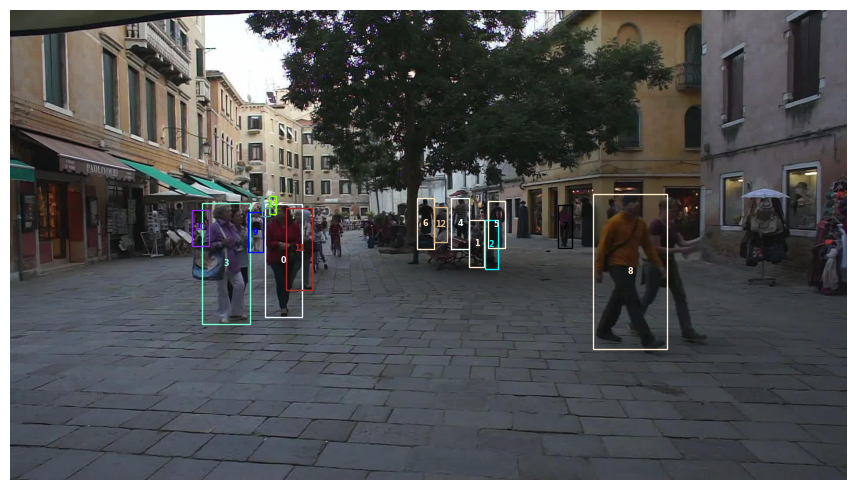

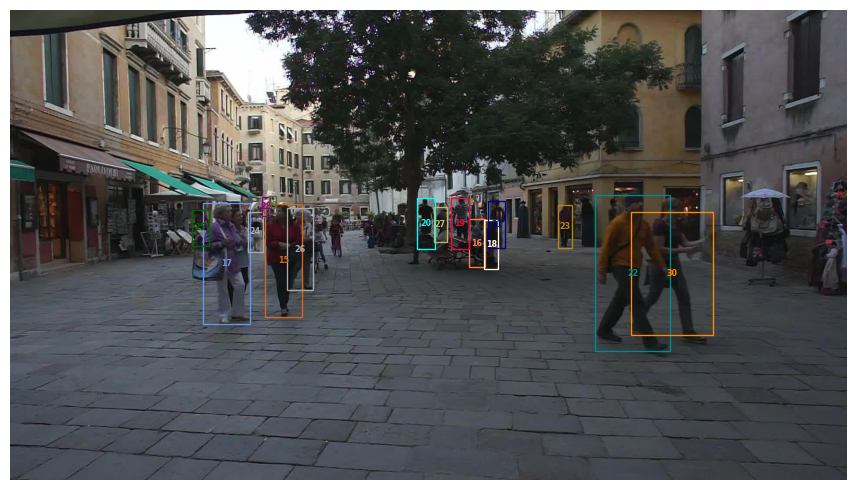

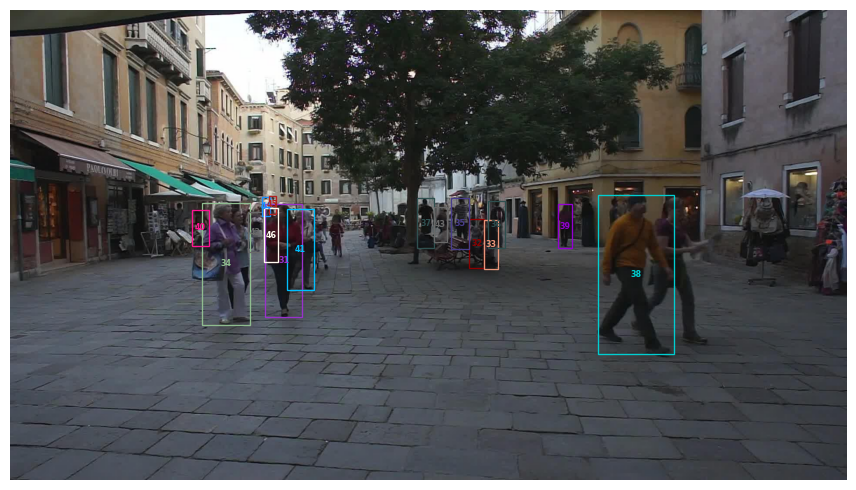

In [18]:
plot_sequence(
    results_seq["MOT16-02"],
    [s for s in val_sequences if str(s) == "MOT16-02"][0],
    first_n_frames=3,
)


# Test data


In [ ]:
best_ckpt = torch.load(osp.join(root_dir, "models", "best_ckpt.pth"))
similarity_net.load_state_dict(best_ckpt)

tracker = MPNTracker(
    similarity_net=similarity_net.eval(), obj_detect=None, patience=MAX_PATIENCE
)
test_db = torch.load(
    osp.join(root_dir, "data/preprocessed_data/preprocessed_data_test_2.pth")
)
val_sequences = MOT16Sequences(
    "MOT16-test", osp.join(root_dir, "data/MOT16"), vis_threshold=0.0
)
run_tracker(val_sequences, db=test_db, tracker=tracker, output_dir=None)
